In [2]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

data=[]
for i in range(10):
    img = cv2.imread('dataset/%s.jpg' %i)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())



In [3]:
import torch
from torch.autograd import Variable

In [53]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))
 
class Perceptron(torch.nn.Module):
 
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(256, 256)  # One in and one out
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
 
# our model
our_model = Perceptron()

In [5]:
def generate_rescaled_inputs(data):
    input_data = []
    
    for i in range(10):
        p = data[i].reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        input_data.append(p)
        
    return input_data

In [6]:
def generate_predictions(data):
    predicted_output = []
    
    for i in range(10):
        p = our_model(Variable(torch.Tensor([data[i]]))).cpu().detach().numpy()
        p = p.reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        predicted_output.append(p)
    
    return predicted_output

In [7]:
def calculate_total_black_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==0)
    return count

In [8]:
def calculate_total_white_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==1)
    return count

In [15]:
def calculate_matching_black_pixels(data1, data2):
    match_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(256):
        match_ctr += 1 if(inp[i]==0 and pred[i]==0) else 0
    return match_ctr

In [10]:
def calculate_mismatching_black_pixels(data1, data2):
    mismatch_ctr = 0
    inp = data1.flatten()
    pred = data2.flatten()
    for i in range(256):
        mismatch_ctr += 1 if(inp[i]==1 and pred[i]==0) else 0
    return mismatch_ctr

In [58]:
def compute_error_metrics(input_data, predicted_output):
    f_h = []
    f_fa = []
    
    for ix, data in enumerate(input_data):
        total_black_pixels = calculate_total_black_pixels(input_data[ix])
        total_hits = calculate_matching_black_pixels(input_data[ix], predicted_output[ix])
        fh_ratio = float(total_hits/total_black_pixels)
        # print("Fraction of hits is ", total_hits, total_black_pixels)
        f_h.append(fh_ratio)
    
    for ix, data in enumerate(input_data):
        total_white_pixels = calculate_total_white_pixels(input_data[ix])
        total_fa = calculate_mismatching_black_pixels(input_data[ix], predicted_output[ix])
        ffa_ratio = float(total_fa/total_white_pixels)
        # print("Fraction of false alarms is ", total_fa, total_white_pixels)
        f_fa.append(ffa_ratio)
    return f_h, f_fa
    

In [13]:
input_data = generate_rescaled_inputs(data)
predicted_output = generate_predictions(data)

In [14]:
fh, ffa = compute_error_metrics(input_data, predicted_output)

Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0


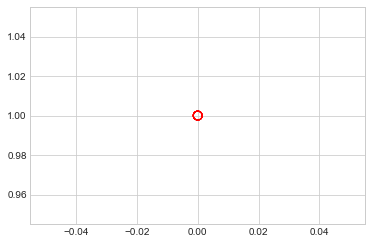

In [15]:
plt.scatter(ffa, fh, s=80, facecolors='none', edgecolors='r')
plt.show()

In [12]:
from random import sample
def add_noise(data, sigma):
    idx = sample(range(256), 25)
    noise = np.random.normal(0, sigma, 25)
    for i in range(25):
        data[idx[i]] += noise[i]
    return data
def normalize(data):
    mini = np.amin(data)
    maxi = np.amax(data)
    for i in range(256):
        data[i] = (data[i] - mini)/(maxi - mini)
    return data

In [43]:
noisy_data = []
for d in data:
    nd = add_noise(np.copy(d), 0.1)
    noisy_data.append(normalize(nd))


In [72]:
our_model = Perceptron()
 
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01)
for test in range(0, 100, 10):
    for epoch in range(test):
    
        # Forward pass: Compute predicted y by passing
        # x to the model
        pred_y = our_model(x_data)
    
        # Compute and print loss
        loss = criterion(pred_y, y_data)
    
        # Zero gradients, perform a backward pass,
        # and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch {}'.format(test))
    
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(noisy_data)
    fh, ffa = compute_error_metrics(target_values, predicted_values)
    print('ffa=', np.mean(ffa))
    print('fh=', np.mean(fh))

epoch 0
ffa= 0.4863259592861266
fh= 0.5106508252379998
epoch 10
ffa= 0.022611994269152204
fh= 0.562208549969447
epoch 20
ffa= 0.015000013312030814
fh= 0.7395153290952475
epoch 30
ffa= 0.0
fh= 0.9922287390029325
epoch 40
ffa= 0.0
fh= 1.0
epoch 50
ffa= 0.0
fh= 1.0
epoch 60
ffa= 0.0
fh= 1.0
epoch 70
ffa= 0.0
fh= 1.0
epoch 80
ffa= 0.0
fh= 1.0
epoch 90
ffa= 0.0
fh= 1.0


[[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]], [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]]


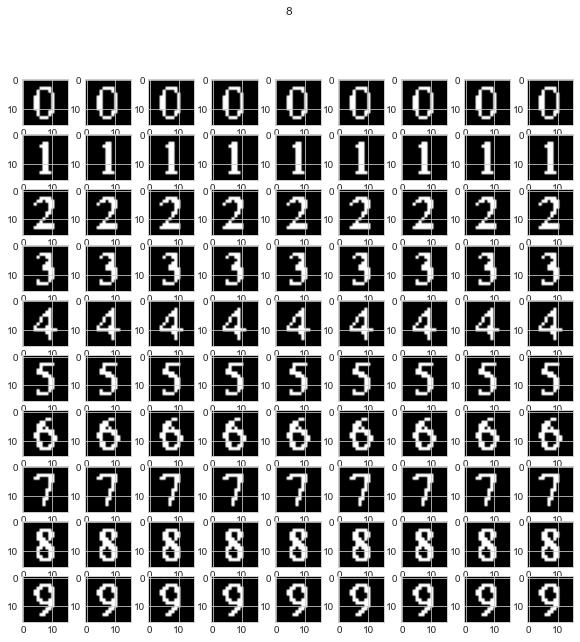

In [67]:
err = []
sigma = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
fig, axs = plt.subplots(10, 9, figsize=(10, 10))
for s in range(9):
    fig.suptitle(s)
    noisy_data = []
    for d in data:
        nd = add_noise(np.copy(d), sigma[s])
        noisy_data.append(normalize(nd))
    target_values = generate_rescaled_inputs(data)
    predicted_values = generate_predictions(noisy_data)
    for i in range(10):
        axs[i, s].imshow(predicted_values[i].reshape(16, 16))
    fh, ffa = compute_error_metrics(target_values, predicted_values)
    err.append([fh, ffa])
print(err)